In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
! export TF_CPP_MIN_LOG_LEVEL=2

## Hardware check

In [3]:
# gpu check
!nvidia-smi

Thu Oct 26 09:14:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3A:00.0 Off |                    0 |
| N/A   32C    P0    41W / 300W |     15MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [4]:
# check number of cores
import multiprocessing

cores = multiprocessing.cpu_count() 
cores

80

## Environment Prep

In [5]:
cd /pfs/data5/home/hd/hd_hd/hd_nf283/MA_Thesis

/pfs/data5/home/hd/hd_hd/hd_nf283/MA_Thesis


In [6]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
# from tensorflow.keras.models import Model
from tensorflow.keras import models
import pickle
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
import pandas as pd
import json
from torch.utils.data import Dataset
from transformers import AutoTokenizer, pipeline, AutoModel
import resources.smart_cond as sc
import gc
# from google.colab import files

In [7]:
import tensorflow as tf
print(tf. __version__)

pickle.format_version

2.12.0


'4.0'

In [8]:
data_path = 'Data/sepsis_removed_0.pkl'
pkl = pickle.load(open(data_path, 'rb'))
data = pkl[0]
oc = pkl[1]
train_ind = pkl[2]
valid_ind = pkl[3]
test_ind = pkl[4]
del pkl

In [9]:
data.loc[data['variable'] == 'Text', 'value'] = 1
data

,ts_ind,hour,variable,value,TABLE,mean,std
0,10223,467.816667,Text,1,noteevents,1.000000,1.000000
1,18407,28.016667,Text,1,noteevents,1.000000,1.000000
2,40300,155.166667,Text,1,noteevents,1.000000,1.000000
3,23747,52.383333,Text,1,noteevents,1.000000,1.000000
4,2357,73.133333,Text,1,noteevents,1.000000,1.000000
...,...,...,...,...,...,...,...
82886223,57281,20.400000,MBP,0.195381,chart,78.552377,17.645628
82886224,57281,20.400000,O2 Saturation,-0.678068,chart,96.820961,4.160290
82886225,57281,20.400000,RR,0.179866,chart,26.278501,15.130729
82886226,57281,20.400000,SBP,-0.404061,chart,120.239648,25.341836


In [10]:
pred_window = 2 # hours
obs_windows = range(20, 124, 4)
# Remove test patients.
data = data.merge(oc[['ts_ind', 'SUBJECT_ID']], on='ts_ind', how='left')
test_sub = oc.loc[oc.ts_ind.isin(test_ind)].SUBJECT_ID.unique()
data = data.loc[~data.SUBJECT_ID.isin(test_sub)]
oc = oc.loc[~oc.SUBJECT_ID.isin(test_sub)]
data.drop(columns=['SUBJECT_ID', 'TABLE'], inplace=True)
# Fix age.
data.loc[(data.variable=='Age')&(data.value>200), 'value'] = 91.4
# data[data.variable=='Age'][data.value>200]['value'] = 91.4

In [11]:
# Get static data with mean fill and missingness indicator.
static_varis = ['Age', 'Gender']
ii = data.variable.isin(static_varis)
static_data = data.loc[ii]
data = data.loc[~ii]
def inv_list(l, start=0):
    d = {}
    for i in range(len(l)):
        d[l[i]] = i+start
    return d
static_var_to_ind = inv_list(static_varis)
D = len(static_varis)
N = data.ts_ind.max()+1
demo = np.zeros((N, D))
for row in tqdm(static_data.itertuples()):
    demo[row.ts_ind, static_var_to_ind[row.variable]] = row.value
# Normalize static data.
means = demo.mean(axis=0, keepdims=True)
stds = demo.std(axis=0, keepdims=True)
stds = (stds==0)*1 + (stds!=0)*stds
demo = (demo-means)/stds
# Get variable indices.
varis = sorted(list(set(data.variable)))
V = len(varis)
var_to_ind = inv_list(varis, start=1)
data['vind'] = data.variable.map(var_to_ind)
data = data[['ts_ind', 'vind', 'hour', 'value']].sort_values(by=['ts_ind', 'vind', 'hour'])
# Find max_len.
fore_max_len = 880
# Get forecast inputs and outputs.
fore_times_ip = []
fore_values_ip = []
fore_varis_ip = []
fore_op = []
fore_inds = []
def f(x):
    mask = [0 for i in range(V)]
    values = [0 for i in range(V)]
    for vv in x:
        v = int(vv[0])-1
        mask[v] = 1
        values[v] = vv[1]
    return values+mask
def pad(x):
    return x+[0]*(fore_max_len-len(x))
for w in tqdm(obs_windows):
    pred_data = data.loc[(data.hour>=w)&(data.hour<=w+pred_window)]
    pred_data = pred_data.groupby(['ts_ind', 'vind']).agg({'value':'first'}).reset_index()
    pred_data['vind_value'] = pred_data[['vind', 'value']].values.tolist()
    pred_data = pred_data.groupby('ts_ind').agg({'vind_value':list}).reset_index()
    pred_data['vind_value'] = pred_data['vind_value'].apply(f)    
    obs_data = data.loc[(data.hour<w)&(data.hour>=w-24)]
    obs_data = obs_data.loc[obs_data.ts_ind.isin(pred_data.ts_ind)]
    obs_data = obs_data.groupby('ts_ind').head(fore_max_len)
    obs_data = obs_data.groupby('ts_ind').agg({'vind':list, 'hour':list, 'value':list}).reset_index()
    obs_data = obs_data.merge(pred_data, on='ts_ind')
    for col in ['vind', 'hour', 'value']:
        obs_data[col] = obs_data[col].apply(pad)
    fore_op.append(np.array(list(obs_data.vind_value)))
    fore_inds.append(np.array(list(obs_data.ts_ind)))
    fore_times_ip.append(np.array(list(obs_data.hour)))
    fore_values_ip.append(np.array(list(obs_data.value)))
    fore_varis_ip.append(np.array(list(obs_data.vind)))
del data
fore_times_ip = np.concatenate(fore_times_ip, axis=0)
fore_values_ip = np.concatenate(fore_values_ip, axis=0)
fore_varis_ip = np.concatenate(fore_varis_ip, axis=0)
fore_op = np.concatenate(fore_op, axis=0)
fore_inds = np.concatenate(fore_inds, axis=0)
fore_demo = demo[fore_inds]
# Get train and valid ts_ind for forecast task.
train_sub = oc.loc[oc.ts_ind.isin(train_ind)].SUBJECT_ID.unique()
valid_sub = oc.loc[oc.ts_ind.isin(valid_ind)].SUBJECT_ID.unique()
rem_sub = oc.loc[~oc.SUBJECT_ID.isin(np.concatenate((train_ind, valid_ind)))].SUBJECT_ID.unique()
bp = int(0.8*len(rem_sub))
train_sub = np.concatenate((train_sub, rem_sub[:bp]))
valid_sub = np.concatenate((valid_sub, rem_sub[bp:]))
train_ind = oc.loc[oc.SUBJECT_ID.isin(train_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
valid_ind = oc.loc[oc.SUBJECT_ID.isin(valid_sub)].ts_ind.unique() # Add remaining ts_ind s of train subjects.
# Generate 3 sets of inputs and outputs.
train_ind = np.argwhere(np.in1d(fore_inds, train_ind)).flatten()
valid_ind = np.argwhere(np.in1d(fore_inds, valid_ind)).flatten()
fore_train_ip = [ip[train_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
fore_valid_ip = [ip[valid_ind] for ip in [fore_demo, fore_times_ip, fore_values_ip, fore_varis_ip]]
del fore_times_ip, fore_values_ip, fore_varis_ip, demo, fore_demo
fore_train_op = fore_op[train_ind]
fore_valid_op = fore_op[valid_ind]
del fore_op

91626it [00:00, 785790.40it/s]
100%|██████████| 26/26 [05:05<00:00, 11.74s/it]


In [ ]:
def get_res(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    minrp = np.minimum(precision, recall).max()
    roc_auc = roc_auc_score(y_true, y_pred)
    return [roc_auc, pr_auc, minrp]

def forecast_loss(y_true, y_pred):
    return K.sum(y_true[:,V:]*(y_true[:,:V]-y_pred)**2, axis=-1)

def get_min_loss(weight):
    def min_loss(y_true, y_pred):
        return weight*y_pred
    return min_loss

class CustomCallback(Callback):
    def __init__(self, validation_data, batch_size):
        self.val_x, self.val_y = validation_data
        self.batch_size = batch_size
        super(Callback, self).__init__()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.val_x, verbose=0, batch_size=self.batch_size)
        if type(y_pred)==type([]):
            y_pred = y_pred[0]
        precision, recall, thresholds = precision_recall_curve(self.val_y, y_pred)
        pr_auc = auc(recall, precision)
        roc_auc = roc_auc_score(self.val_y, y_pred)
        logs['custom_metric'] = pr_auc + roc_auc
        print ('val_aucs:', pr_auc, roc_auc)

In [15]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Embedding, Activation, Dropout, Softmax, Layer, InputSpec, Input, Dense, Lambda, TimeDistributed, Concatenate, Add
from tensorflow.keras import initializers, regularizers, constraints, Model
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow import nn

    
class CVE(Layer):
    def __init__(self, hid_units, output_dim):
        self.hid_units = hid_units
        self.output_dim = output_dim
        super(CVE, self).__init__()
        
    def build(self, input_shape): 
        self.W1 = self.add_weight(name='CVE_W1',
                            shape=(1, self.hid_units),
                            initializer='glorot_uniform',
                            trainable=True)
        self.b1 = self.add_weight(name='CVE_b1',
                            shape=(self.hid_units,),
                            initializer='zeros',
                            trainable=True)
        self.W2 = self.add_weight(name='CVE_W2',
                            shape=(self.hid_units, self.output_dim),
                            initializer='glorot_uniform',
                            trainable=True)
        super(CVE, self).build(input_shape)
        
    def call(self, x):
        x = K.expand_dims(x, axis=-1)
        x = K.dot(K.tanh(K.bias_add(K.dot(x, self.W1), self.b1)), self.W2)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape + (self.output_dim,)
    
    
class Attention(Layer):
    
    def __init__(self, hid_dim):
        self.hid_dim = hid_dim
        super(Attention, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        self.W = self.add_weight(shape=(d, self.hid_dim), name='Att_W',
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.hid_dim,), name='Att_b',
                                 initializer='zeros',
                                 trainable=True)
        self.u = self.add_weight(shape=(self.hid_dim,1), name='Att_u',
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(Attention, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e30):
        attn_weights = K.dot(K.tanh(K.bias_add(K.dot(x,self.W), self.b)), self.u)
        mask = K.expand_dims(mask, axis=-1)
        attn_weights = mask*attn_weights + (1-mask)*mask_value
        attn_weights = K.softmax(attn_weights, axis=-2)
        return attn_weights
        
    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (1,)
    
    
class Transformer(Layer):
    
    def __init__(self, N=2, h=8, dk=None, dv=None, dff=None, dropout=0):
        self.N, self.h, self.dk, self.dv, self.dff, self.dropout = N, h, dk, dv, dff, dropout
        self.epsilon = K.epsilon() * K.epsilon()
        super(Transformer, self).__init__()

    def build(self, input_shape):
        d = input_shape.as_list()[-1]
        if self.dk==None:
            self.dk = d//self.h
        if self.dv==None:
            self.dv = d//self.h
        if self.dff==None:
            self.dff = 2*d
        self.Wq = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wq',
                                 initializer='glorot_uniform', trainable=True)
        self.Wk = self.add_weight(shape=(self.N, self.h, d, self.dk), name='Wk',
                                 initializer='glorot_uniform', trainable=True)
        self.Wv = self.add_weight(shape=(self.N, self.h, d, self.dv), name='Wv',
                                 initializer='glorot_uniform', trainable=True)
        self.Wo = self.add_weight(shape=(self.N, self.dv*self.h, d), name='Wo',
                                 initializer='glorot_uniform', trainable=True)
        self.W1 = self.add_weight(shape=(self.N, d, self.dff), name='W1',
                                 initializer='glorot_uniform', trainable=True)
        self.b1 = self.add_weight(shape=(self.N, self.dff), name='b1',
                                 initializer='zeros', trainable=True)
        self.W2 = self.add_weight(shape=(self.N, self.dff, d), name='W2',
                                 initializer='glorot_uniform', trainable=True)
        self.b2 = self.add_weight(shape=(self.N, d), name='b2',
                                 initializer='zeros', trainable=True)
        self.gamma = self.add_weight(shape=(2*self.N,), name='gamma',
                                 initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(2*self.N,), name='beta',
                                 initializer='zeros', trainable=True)
        super(Transformer, self).build(input_shape)
        
    def call(self, x, mask, mask_value=-1e-30):
        mask = K.expand_dims(mask, axis=-2)
        for i in range(self.N):
            # MHA
            mha_ops = []
            for j in range(self.h):
                q = K.dot(x, self.Wq[i,j,:,:])
                k = K.permute_dimensions(K.dot(x, self.Wk[i,j,:,:]), (0,2,1))
                v = K.dot(x, self.Wv[i,j,:,:])
                A = K.batch_dot(q,k)
                # Mask unobserved steps.
                A = mask*A + (1-mask)*mask_value
                # Mask for attention dropout.
                def dropped_A():
                    dp_mask = K.cast((K.random_uniform(shape=array_ops.shape(A))>=self.dropout), K.floatx())
                    return A*dp_mask + (1-dp_mask)*mask_value
                A = sc.smart_cond(K.learning_phase(), dropped_A, lambda: array_ops.identity(A))
                A = K.softmax(A, axis=-1)
                mha_ops.append(K.batch_dot(A,v))
            conc = K.concatenate(mha_ops, axis=-1)
            proj = K.dot(conc, self.Wo[i,:,:])
            # Dropout.
            proj = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(proj, rate=self.dropout)),\
                                       lambda: array_ops.identity(proj))
            # Add & LN
            x = x+proj
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i] + self.beta[2*i]
            # FFN
            ffn_op = K.bias_add(K.dot(K.relu(K.bias_add(K.dot(x, self.W1[i,:,:]), self.b1[i,:])), 
                           self.W2[i,:,:]), self.b2[i,:,])
            # Dropout.
            ffn_op = sc.smart_cond(K.learning_phase(), lambda: array_ops.identity(nn.dropout(ffn_op, rate=self.dropout)),\
                                       lambda: array_ops.identity(ffn_op))
            # Add & LN
            x = x+ffn_op
            mean = K.mean(x, axis=-1, keepdims=True)
            variance = K.mean(K.square(x - mean), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            x = (x - mean) / std
            x = x*self.gamma[2*i+1] + self.beta[2*i+1]            
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape


def build_strats(D, max_len, V, d, N, he, dropout, forecast=False):
    demo = Input(shape=(D,))
    demo_enc = Dense(2*d, activation='tanh')(demo)
    demo_enc = Dense(d, activation='tanh')(demo_enc)
    varis = Input(shape=(max_len,))
    values = Input(shape=(max_len,))
    times = Input(shape=(max_len,))
    varis_emb = Embedding(V+1, d)(varis)
    cve_units = int(np.sqrt(d))
    values_emb = CVE(cve_units, d)(values)
    times_emb = CVE(cve_units, d)(times)
    comb_emb = Add()([varis_emb, values_emb, times_emb]) # b, L, d
#     demo_enc = Lambda(lambda x:K.expand_dims(x, axis=-2))(demo_enc) # b, 1, d
#     comb_emb = Concatenate(axis=-2)([demo_enc, comb_emb]) # b, L+1, d
    mask = Lambda(lambda x:K.clip(x,0,1))(varis) # b, L
#     mask = Lambda(lambda x:K.concatenate((K.ones_like(x)[:,0:1], x), axis=-1))(mask) # b, L+1
    cont_emb = Transformer(N, he, dk=None, dv=None, dff=None, dropout=dropout)(comb_emb, mask=mask)
    attn_weights = Attention(2*d)(cont_emb, mask=mask)
    fused_emb = Lambda(lambda x:K.sum(x[0]*x[1], axis=-2))([cont_emb, attn_weights])
    conc = Concatenate(axis=-1)([fused_emb, demo_enc])
    fore_op = Dense(V)(conc)
    op = Dense(1, activation='sigmoid')(fore_op)
    model = Model([demo, times, values, varis], op)
    if forecast:
        fore_model = Model([demo, times, values, varis], fore_op)
        return [model, fore_model]
    return model

# To tune:
# 1. Transformer parameters. (N, h, dropout)
# 2. Normalization

In [18]:
lr, batch_size, samples_per_epoch, patience = 0.0005, 32, 102400, 5
d, N, he, dropout = 50, 2, 4, 0.2
model, fore_model =  build_strats(D, fore_max_len, V, d, N, he, dropout, forecast=True)
print (fore_model.summary())
fore_model.compile(loss=forecast_loss, optimizer=Adam(lr))

# Pretrain fore_model.
best_val_loss = np.inf
N_fore = len(fore_train_op)
fore_savepath = 'Baseline/models/forecasting/strats_baseline_forecasting.h5'

train_losses = []
val_losses = []

for e in range(1000):
    e_indices = np.random.choice(range(N_fore), size=samples_per_epoch, replace=False)
    e_loss = 0
    pbar = tqdm(range(0, len(e_indices), batch_size))
    for start in pbar:
        ind = e_indices[start:start+batch_size]
        e_loss += fore_model.train_on_batch([ip[ind] for ip in fore_train_ip], fore_train_op[ind])
        pbar.set_description('%f'%(e_loss/(start+1)))
    val_loss = fore_model.evaluate(fore_valid_ip, fore_valid_op, batch_size=batch_size, verbose=1)
    
    train_losses.append(e_loss*batch_size/samples_per_epoch)
    val_losses.append(val_loss)
    
    print ('Epoch', e, 'loss', e_loss*batch_size/samples_per_epoch, 'val loss', val_loss)
    
    print(train_losses)
    print(val_losses)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        fore_model.save_weights(fore_savepath)
        best_epoch = e
    if (e-best_epoch)>patience:
        break

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 880)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 880)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 880)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 880, 50)      6750        ['input_14[0][0]']               
                                                                                            

0.279997: 100%|██████████| 3200/3200 [02:36<00:00, 20.43it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 7.5740
Epoch 0 loss 8.957182633876801 val loss 7.574024677276611
[8.957182633876801]
[7.574024677276611]


0.232706: 100%|██████████| 3200/3200 [02:30<00:00, 21.24it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 6.8715
Epoch 1 loss 7.444346153885126 val loss 6.8714728355407715
[8.957182633876801, 7.444346153885126]
[7.574024677276611, 6.8714728355407715]


0.210005: 100%|██████████| 3200/3200 [02:30<00:00, 21.33it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 6.6017
Epoch 2 loss 6.718132002651691 val loss 6.6017351150512695
[8.957182633876801, 7.444346153885126, 6.718132002651691]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695]


0.206505: 100%|██████████| 3200/3200 [02:30<00:00, 21.29it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 6.4054
Epoch 3 loss 6.606167373768986 val loss 6.405410289764404
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404]


0.198001: 100%|██████████| 3200/3200 [02:29<00:00, 21.38it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 6.3083
Epoch 4 loss 6.334112568087876 val loss 6.308310508728027
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027]


0.194515: 100%|██████████| 3200/3200 [02:30<00:00, 21.30it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 6.0931
Epoch 5 loss 6.222601437494159 val loss 6.093061923980713
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713]


0.190653: 100%|██████████| 3200/3200 [02:29<00:00, 21.38it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.9928
Epoch 6 loss 6.099050151444971 val loss 5.992845058441162
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162]


0.187844: 100%|██████████| 3200/3200 [02:31<00:00, 21.08it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 6.1076
Epoch 7 loss 6.009203886091709 val loss 6.107646465301514
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514]


0.180394: 100%|██████████| 3200/3200 [02:30<00:00, 21.21it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.9393
Epoch 8 loss 5.77085709810257 val loss 5.939321994781494
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494]


0.185988: 100%|██████████| 3200/3200 [02:30<00:00, 21.28it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.7845
Epoch 9 loss 5.949807133153081 val loss 5.784503936767578
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578]


0.181404: 100%|██████████| 3200/3200 [02:30<00:00, 21.27it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.8121
Epoch 10 loss 5.8031801933795215 val loss 5.81207275390625
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625]


0.176166: 100%|██████████| 3200/3200 [02:30<00:00, 21.31it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.7781
Epoch 11 loss 5.635595956072211 val loss 5.778130054473877
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877]


0.181265: 100%|██████████| 3200/3200 [02:30<00:00, 21.32it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.7172
Epoch 12 loss 5.798708248250186 val loss 5.717212677001953
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953]


0.177762: 100%|██████████| 3200/3200 [02:30<00:00, 21.27it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.6572
Epoch 13 loss 5.686658313274384 val loss 5.657232284545898
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898]


0.175607: 100%|██████████| 3200/3200 [02:36<00:00, 20.41it/s]


4276/4276 [==============================] - 70s 16ms/step - loss: 5.5747
Epoch 14 loss 5.617710028290748 val loss 5.574744701385498
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498]


0.173384: 100%|██████████| 3200/3200 [02:32<00:00, 20.94it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.6004
Epoch 15 loss 5.546603025831282 val loss 5.6003875732421875
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875]


0.170175: 100%|██████████| 3200/3200 [02:32<00:00, 21.05it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.6967
Epoch 16 loss 5.4439452893659475 val loss 5.6966986656188965
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965]


0.174090: 100%|██████████| 3200/3200 [02:32<00:00, 21.02it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.5241
Epoch 17 loss 5.569199087247252 val loss 5.5241217613220215
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215]


0.170060: 100%|██████████| 3200/3200 [02:32<00:00, 21.00it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.5555
Epoch 18 loss 5.440258623324334 val loss 5.555541515350342
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342]


0.176025: 100%|██████████| 3200/3200 [02:32<00:00, 21.03it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.5845
Epoch 19 loss 5.6310957011580465 val loss 5.584465503692627
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.584465503692627]


0.171052: 100%|██████████| 3200/3200 [02:32<00:00, 21.02it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.4864
Epoch 20 loss 5.472006217092275 val loss 5.486431121826172
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.584465503692627, 5.486431121826172]


0.169549: 100%|██████████| 3200/3200 [02:32<00:00, 21.04it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.5010
Epoch 21 loss 5.4239358650147915 val loss 5.501025199890137
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.584465503692627, 5.486431121826172, 5.501025199890137]


0.169125: 100%|██████████| 3200/3200 [02:33<00:00, 20.90it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.4396
Epoch 22 loss 5.410358652472496 val loss 5.439569473266602
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.584465503692627, 5.486431121826172, 5.501025199890137, 5.4

0.170585: 100%|██████████| 3200/3200 [02:31<00:00, 21.08it/s]


4276/4276 [==============================] - 74s 17ms/step - loss: 5.7204
Epoch 23 loss 5.457051942534744 val loss 5.72035551071167
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496, 5.457051942534744]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.584465503692627, 5.486431121826172, 5.50

0.163943: 100%|██████████| 3200/3200 [02:32<00:00, 21.01it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.5538
Epoch 24 loss 5.244602517709136 val loss 5.5537919998168945
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496, 5.457051942534744, 5.244602517709136]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.584465503692627, 5.

0.172901: 100%|██████████| 3200/3200 [02:30<00:00, 21.23it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.4441
Epoch 25 loss 5.531149811521172 val loss 5.444085597991943
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496, 5.457051942534744, 5.244602517709136, 5.531149811521172]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.5

0.172108: 100%|██████████| 3200/3200 [02:30<00:00, 21.31it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.4486
Epoch 26 loss 5.505790843628347 val loss 5.448609828948975
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496, 5.457051942534744, 5.244602517709136, 5.531149811521172, 5.505790843628347]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.5

0.172269: 100%|██████████| 3200/3200 [02:31<00:00, 21.17it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.4656
Epoch 27 loss 5.510934510603547 val loss 5.465628147125244
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496, 5.457051942534744, 5.244602517709136, 5.531149811521172, 5.505790843628347, 5.510934510603547]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.52

0.166915: 100%|██████████| 3200/3200 [02:31<00:00, 21.18it/s]


4276/4276 [==============================] - 69s 16ms/step - loss: 5.4541
Epoch 28 loss 5.33967715986073 val loss 5.454106330871582
[8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496, 5.457051942534744, 5.244602517709136, 5.531149811521172, 5.505790843628347, 5.510934510603547, 5.33967715986073]
[7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.69669

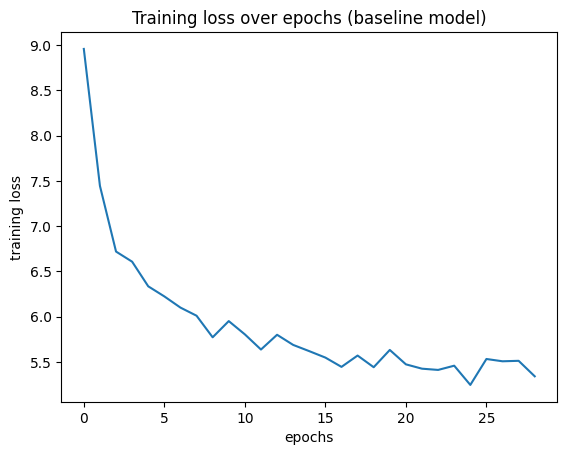

In [9]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = [8.957182633876801, 7.444346153885126, 6.718132002651691, 6.606167373768986, 6.334112568087876, 6.222601437494159, 6.099050151444971, 6.009203886091709, 5.77085709810257, 5.949807133153081, 5.8031801933795215, 5.635595956072211, 5.798708248250186, 5.686658313274384, 5.617710028290748, 5.546603025831282, 5.4439452893659475, 5.569199087247252, 5.440258623324334, 5.6310957011580465, 5.472006217092275, 5.4239358650147915, 5.410358652472496, 5.457051942534744, 5.244602517709136, 5.531149811521172, 5.505790843628347, 5.510934510603547, 5.33967715986073]
plt.plot(train_losses)
plt.title('Training loss over epochs (baseline model)')
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.savefig('plots/train_losses.png')
plt.show()

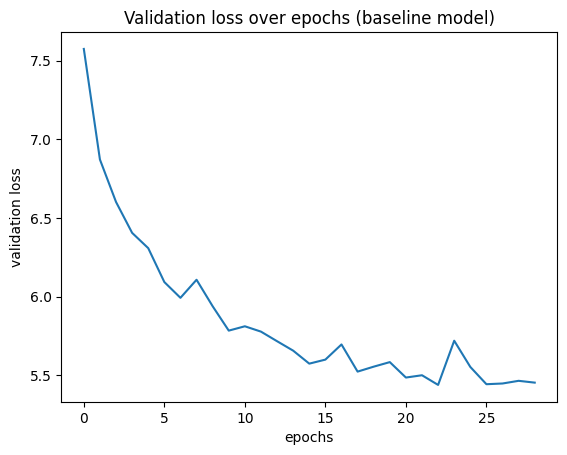

In [10]:
val_losses = [7.574024677276611, 6.8714728355407715, 6.6017351150512695, 6.405410289764404, 6.308310508728027, 6.093061923980713, 5.992845058441162, 6.107646465301514, 5.939321994781494, 5.784503936767578, 5.81207275390625, 5.778130054473877, 5.717212677001953, 5.657232284545898, 5.574744701385498, 5.6003875732421875, 5.6966986656188965, 5.5241217613220215, 5.555541515350342, 5.584465503692627, 5.486431121826172, 5.501025199890137, 5.439569473266602, 5.72035551071167, 5.5537919998168945, 5.444085597991943, 5.448609828948975, 5.465628147125244, 5.454106330871582]
plt.plot(val_losses)
plt.title('Validation loss over epochs (baseline model)')
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.savefig('plots/validation_losses.png')
plt.show()